In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [2]:
!git clone https://gitlab.astro.rug.nl/ardevol/exocnn.git

Cloning into 'exocnn'...
remote: Enumerating objects: 7366, done.
remote: Counting objects: 100% (12/12), done.
remote: Compressing objects: 100% (12/12), done.
remote: Total 7366 (delta 5), reused 0 (delta 0), pack-reused 7354
Receiving objects: 100% (7366/7366), 1013.45 MiB | 33.83 MiB/s, done.
Resolving deltas: 100% (6920/6920), done.
Updating files: 100% (7300/7300), done.


In [3]:
cd /kaggle/working/exocnn/Code

/kaggle/working/exocnn/Code


In [4]:
! ls

Analyses.ipynb	    Retrievals.ipynb  __pycache__
Corner_plots.ipynb  Training.ipynb    exobaconn.py


In [5]:
pip install corner

Note: you may need to restart the kernel to use updated packages.


In [6]:
pip install spectres

Note: you may need to restart the kernel to use updated packages.


In [7]:
from exobaconn import read_grid, add_noise, bCNN, normalize, load_cnn, true_vs_pred
import numpy as np
import matplotlib.pyplot as plt
import tensorflow.keras as tfk
plt.rc('font', size=14)
from sklearn.preprocessing import MinMaxScaler
from tqdm import trange
import pickle

md = pickle.load(open('../Data/metadata.p', 'rb'))

In [8]:
Type = 1
instrument = 'WFC3'

In [9]:
f_trans = '../Data/Training_Sets/trans_type'+ str(Type)+'.npy'
f_param = '../Data/Training_Sets/parameters_type'+ str(Type)+'.npy'
noise   = md['Noise'][instrument]
wvl     = md['Wavelength']['NIRSPEC']
new_wvl = md['Wavelength'][instrument]

In [10]:
N_aug  = [20, 1]
ntrain = {1:68000, 2:64000}[Type]
ntest  = 8000

In [11]:
X_train, Y_train, X_test, Y_test = read_grid(f_trans, f_param, wvl=wvl, new_wvl=new_wvl, n_train=ntrain, n_test=ntest, 
                                             N_aug=N_aug)

X_train = 0.752**2*add_noise(X_train, noise, floor=5)
X_test  = 0.752**2*add_noise(X_test , noise, floor=5)

Loading files...
Rebinning spectra
X_train...
Y_train...
X_test...
Y_test...


In [12]:
#np.shape(Yt_train)

In [13]:
#np.shape(Yt_test)

In [14]:
Yt_train = Y_train[:,0:1]
Yt_test = Y_test[:,0:1]

In [15]:
#Yt_train = Y_train[:,0:1]
#Yt_test = Y_test[:,0:1]

Epoch 1 loss: 2038185.846 R^2: -0.024
Epoch 2 loss: 1954548.247 R^2: 0.019
Epoch 3 loss: 1938975.528 R^2: 0.026
Epoch 4 loss: 1926645.460 R^2: 0.032
Epoch 5 loss: 1911676.394 R^2: 0.040
Epoch 6 loss: 1884459.316 R^2: 0.054
Epoch 7 loss: 1849986.421 R^2: 0.071
Epoch 8 loss: 1825180.396 R^2: 0.083
Epoch 9 loss: 1806046.103 R^2: 0.093
Epoch 10 loss: 1790756.237 R^2: 0.100
Epoch 11 loss: 1776763.243 R^2: 0.107
Epoch 12 loss: 1762583.533 R^2: 0.115
Epoch 13 loss: 1754000.129 R^2: 0.119
Epoch 14 loss: 1726858.060 R^2: 0.132
Epoch 15 loss: 1721491.376 R^2: 0.135
Epoch 16 loss: 1697880.750 R^2: 0.147
Epoch 17 loss: 1690752.670 R^2: 0.150
Epoch 18 loss: 1687437.759 R^2: 0.152
Epoch 19 loss: 1692944.396 R^2: 0.149
Epoch 20 loss: 1672112.453 R^2: 0.160
Epoch 21 loss: 1665272.498 R^2: 0.163
Epoch 22 loss: 1664150.629 R^2: 0.164
Epoch 23 loss: 1653805.808 R^2: 0.169
Epoch 24 loss: 1660040.317 R^2: 0.166
Epoch 25 loss: 1649544.956 R^2: 0.171
Epoch 26 loss: 1647866.320 R^2: 0.172
Epoch 27 loss: 16341

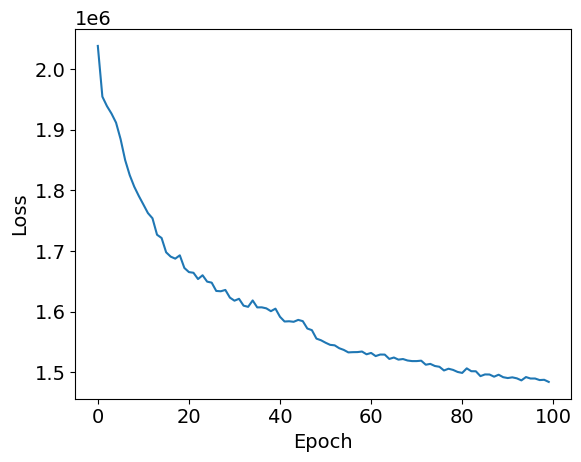

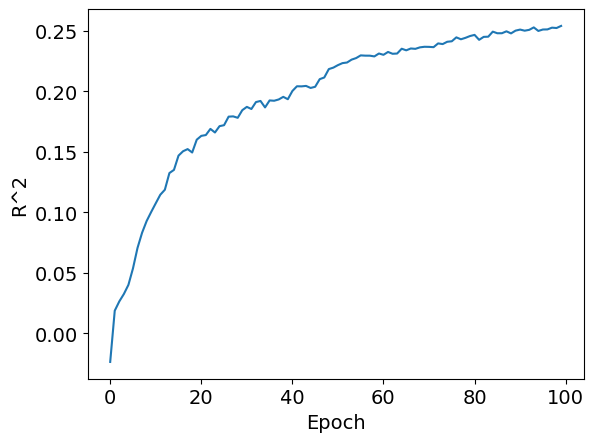

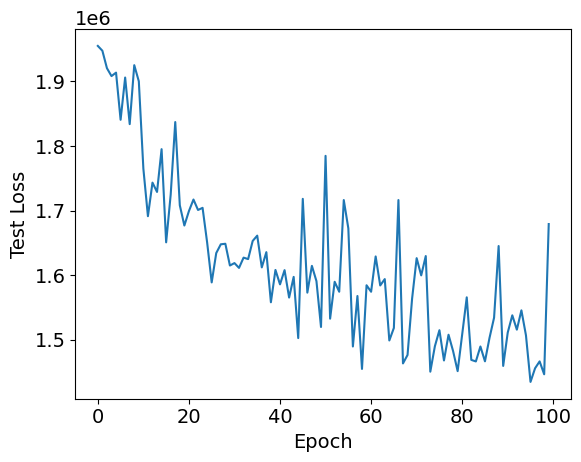

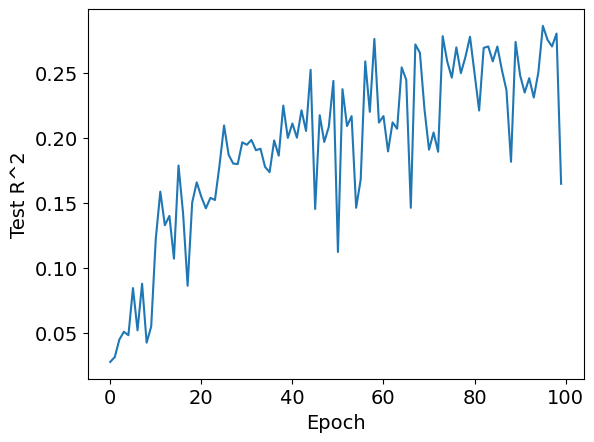

In [16]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import matplotlib.pyplot as plt

# Define the neural network
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.fc1 = nn.Linear(25, 64)
        self.fc2 = nn.Linear(64, 128)
        self.fc3 = nn.Linear(128, 64)
        self.fc4 = nn.Linear(64, 32)
        self.fc5 = nn.Linear(32, 1)

    def forward(self, x):
        x = torch.relu(self.fc1(x))
        x = torch.relu(self.fc2(x))
        x = torch.relu(self.fc3(x))
        x = torch.relu(self.fc4(x))
        x = self.fc5(x)
        return x

# Define the R^2 loss function
class R2Loss(nn.Module):
    def __init__(self):
        super(R2Loss, self).__init__()

    def forward(self, y_pred, y_true):
        ss_res = torch.sum(torch.square(y_true - y_pred))
        ss_tot = torch.sum(torch.square(y_true - torch.mean(y_true)))
        r2 = 1 - ss_res / ss_tot
        return r2

# Define the training function
def train(net, trainloader, criterion, optimizer, epochs, device):
    net.to(device)
    losses = []
    r2s = []
    test_losses = []
    test_r2s = []
    for epoch in range(epochs):
        running_loss = 0.0
        running_r2 = 0.0
        for i, data in enumerate(trainloader, 0):
            inputs, labels = data
            inputs, labels = inputs.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = net(inputs)
            loss = criterion(outputs, labels)
            r2 = R2Loss()(outputs, labels)
            loss += r2
            loss.backward()
            optimizer.step()
            running_loss += loss.item()
            running_r2 += r2.item()
        losses.append(running_loss / len(trainloader))
        r2s.append(running_r2 / len(trainloader))
        print('Epoch %d loss: %.3f R^2: %.3f' % (epoch + 1, running_loss / len(trainloader), running_r2 / len(trainloader)))
        # Test the neural network on the test data
        test_data = X_test
        test_labels = Yt_test
        test_data = torch.from_numpy(test_data).float()
        test_labels = torch.from_numpy(test_labels).float()
        net.eval()
        with torch.no_grad():
            test_data, test_labels = test_data.to(device), test_labels.to(device)
            test_outputs = net(test_data)
            test_loss = criterion(test_outputs, test_labels)
            test_r2 = R2Loss()(test_outputs, test_labels)
            test_losses.append(test_loss.item())
            test_r2s.append(test_r2.item())
    plt.plot(losses)
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.show()
    plt.plot(r2s)
    plt.xlabel('Epoch')
    plt.ylabel('R^2')
    plt.show()
    plt.plot(test_losses)
    plt.xlabel('Epoch')
    plt.ylabel('Test Loss')
    plt.show()
    plt.plot(test_r2s)
    plt.xlabel('Epoch')
    plt.ylabel('Test R^2')
    plt.show()

# Define the data
data = X_train 
labels = Yt_train 

# Convert the data to PyTorch tensors
data = torch.from_numpy(data).float()
labels = torch.from_numpy(labels).float()

# Define the data loader
trainset = torch.utils.data.TensorDataset(data, labels)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=100, shuffle=True)

# Define the neural network
net = Net()

# Define the loss function and optimizer
criterion = nn.MSELoss()
optimizer = optim.Adam(net.parameters(), lr=0.001)

# Define the device
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

# Train the neural network on GPU
train(net, trainloader, criterion, optimizer, epochs=100, device=device)

In [17]:
#dfxtr = pd.DataFrame(X_train)

In [18]:
#dfxte = pd.DataFrame(X_test)

In [19]:
#dfytr = pd.DataFrame(Y_train)

In [20]:
#dfyte = pd.DataFrame(Y_test)

In [21]:
#temp = dfytr[0]

In [22]:
#dfxtr.insert(25, "25", temp)

In [23]:
#dfxtr.to_csv('cnn_exo_temp.csv')